In [1]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 6.8 MB/s 
     |████████████████████████████████| 895 kB 63.3 MB/s 
     |████████████████████████████████| 61 kB 649 kB/s 
     |████████████████████████████████| 3.3 MB 23.4 MB/s 
     |████████████████████████████████| 596 kB 91.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import collections
import numpy as np
import re
from nltk.corpus import stopwords
import copy
import torch

from torch.utils.data import TensorDataset,random_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import time
from sklearn.metrics import classification_report,accuracy_score,f1_score



In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### FRENCH DATASET ANALYSIS

In [6]:
FRENCH_HOF = []
FRENCH_NOT = []

In [7]:
french_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/french_tweets-003.csv', error_bad_lines=False)
print(french_df_2019.shape)
french_df_2019 = french_df_2019.sample(frac=0.025)
print(french_df_2019.shape)
from sklearn.model_selection import train_test_split
french_df_2019, french_df_2019t = train_test_split(french_df_2019, test_size=0.2)

french_df_2019.reset_index(inplace=True)
french_df_2019t.reset_index(inplace=True)

print(french_df_2019.shape)
print(french_df_2019.head())
labels = collections.Counter(french_df_2019['label'])
FRENCH_HOF.append(labels[1])
FRENCH_NOT.append(labels[0])
print(labels)
print(french_df_2019.columns)

labels = collections.Counter(french_df_2019['label'])
print(labels)
french_df_2019.head()

(199987, 2)
(5000, 2)
(4000, 3)
    index  label                                               text
0   28990      0                     Ne peut pas le faire. travail.
1   13525      0  Aw! Je veux un chiot ... appelle-la quelque ch...
2   71945      0  On dirait qu'il veut pleuvoir ici, mais je sai...
3  114318      0  Joyeux jour papa papa je t'aime! Travailler au...
4  105232      0  Pourquoi suis-je en train de nourrir les enfan...
Counter({0: 3470, 1: 530})
Index(['index', 'label', 'text'], dtype='object')
Counter({0: 3470, 1: 530})


,index,label,text
0,28990,0,Ne peut pas le faire. travail.
1,13525,0,Aw! Je veux un chiot ... appelle-la quelque ch...
2,71945,0,"On dirait qu'il veut pleuvoir ici, mais je sai..."
3,114318,0,Joyeux jour papa papa je t'aime! Travailler au...
4,105232,0,Pourquoi suis-je en train de nourrir les enfan...


In [8]:
print(french_df_2019[french_df_2019['label'] == 1]['text'].iloc[10])
print(french_df_2019[french_df_2019['label'] == 0]['text'].iloc[10])

Bonjour, allez sur twitter. Beaucoup de gens vraiment drôles à suivre, alors allez-y. Tu me manques à la télé (je suis la soeur de nina et bien)
En Allemagne, au moins, je peux aller faire du shopping et avoir un Schnitzel wiener ... je manque mes chien


In [9]:
print(french_df_2019t.shape)
print(french_df_2019t.head())
labels = collections.Counter(french_df_2019t['label'])
FRENCH_HOF.append(labels[1])
FRENCH_NOT.append(labels[0])
print(labels)
print(french_df_2019t.columns)
french_df_2019t.head()

(1000, 3)
    index  label                                               text
0  162677      0  Woooooooo a mis mes collines saison 4 dvd box ...
1   70796      0      Je suis si jaloux ... J'aimerais avoir 19 ans
2  130047      0   Wow midterms est brutal. Seulement 5 ans de plus
3  137225      0  Mon PC est en train de mourir ... doit acheter...
4  170124      0  Tout n'est pas bien dans jailbreakland, appare...
Counter({0: 852, 1: 148})
Index(['index', 'label', 'text'], dtype='object')


,index,label,text
0,162677,0,Woooooooo a mis mes collines saison 4 dvd box ...
1,70796,0,Je suis si jaloux ... J'aimerais avoir 19 ans
2,130047,0,Wow midterms est brutal. Seulement 5 ans de plus
3,137225,0,Mon PC est en train de mourir ... doit acheter...
4,170124,0,"Tout n'est pas bien dans jailbreakland, appare..."


([<matplotlib.axis.XTick at 0x7f132ac35f90>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

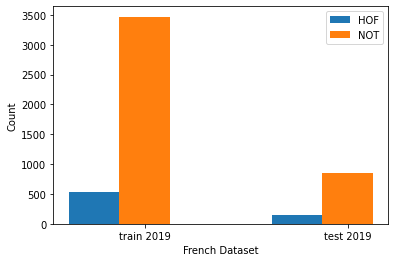

In [10]:
barWidth = 0.25
br1 = np.arange(len(FRENCH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, FRENCH_HOF, width=barWidth, label='HOF')
plt.bar(br2, FRENCH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('French Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

###ENGLISH DATASET ANALYSIS

In [11]:
ENGLISH_HOF = []
ENGLISH_NOT = []

In [12]:
english_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/english_dataset/english_dataset_2019.csv', error_bad_lines=False)
english_df_2019 = english_df_2019.drop(columns=['task_2', 'task_3'])
print(english_df_2019.shape)
labels = collections.Counter(english_df_2019['task_1'])
ENGLISH_HOF.append(labels['HOF'])
ENGLISH_NOT.append(labels['NOT'])
print(labels)
print(english_df_2019.columns)
english_df_2019.head()

(5852, 3)
Counter({'NOT': 3591, 'HOF': 2261})
Index(['text_id', 'text', 'task_1'], dtype='object')


,text_id,text,task_1
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT


In [13]:
# english_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_2020.csv', error_bad_lines=False)
# english_df_2020 = english_df_2020.drop(columns=['task2'])
# print(english_df_2020.shape)
# print(english_df_2020.columns)
# labels = collections.Counter(english_df_2020['task1'])
# ENGLISH_HOF.append(labels['HOF'])
# ENGLISH_NOT.append(labels['NOT'])
# print(labels)
# english_df_2020.head()

In [14]:
english_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/english_dataset/english_dataset_test_2019.csv', error_bad_lines=False)
print(english_df_2019t.columns)
english_df_2019t = english_df_2019t.drop(columns=['task_2', 'task_3'])
print(english_df_2019t.shape)
labels = collections.Counter(english_df_2019t['task_1'])
ENGLISH_HOF.append(labels['HOF'])
ENGLISH_NOT.append(labels['NOT'])
print(labels)
english_df_2019t.head()

Index(['text_id', 'text', 'task_1', 'task_2', 'task_3'], dtype='object')
(1153, 3)
Counter({'NOT': 865, 'HOF': 288})


,text_id,text,task_1
0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,NOT
1,hasoc_en_416,68.5 million people have been forced to leave ...,NOT
2,hasoc_en_207,"You came, you saw .... we will look after the ...",NOT
3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,NOT
4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,HOF


In [15]:
# english_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_test_2020.csv', error_bad_lines=False)
# english_df_2020t = english_df_2020t.drop(columns=['task2'])
# print(english_df_2020t.shape)
# print(english_df_2020t.columns)
# labels = collections.Counter(english_df_2020t['task1'])
# ENGLISH_HOF.append(labels['HOF'])
# ENGLISH_NOT.append(labels['NOT'])
# print(labels)
# english_df_2020t.head()

([<matplotlib.axis.XTick at 0x7f132aea7110>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

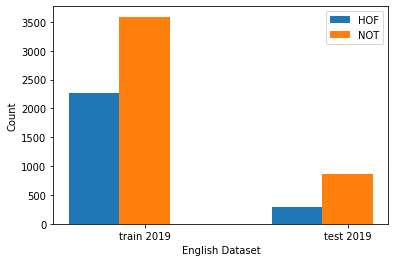

In [16]:
barWidth = 0.25
br1 = np.arange(len(ENGLISH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, ENGLISH_HOF, width=barWidth, label='HOF')
plt.bar(br2, ENGLISH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('English Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

In [17]:
print(english_df_2019[english_df_2019['task_1'] == 'HOF']['text'].iloc[20])
print(english_df_2019t[english_df_2019t['task_1'] == 'NOT']['text'].iloc[10])

@UROCKlive1 He’s had the worst numbers of any president ever. Theres not much “Lower” to go. #TrumpIsATraitor
Kathy Zhu, a supporter of President Trump, was stripped of her title because of comments about African-Americans and Muslims.


###SPANISH DATASET ANALYSIS

In [18]:
SPANISH_HOF = []
SPANISH_NOT = []

In [19]:
spanish_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/spanish_dataset/spanish_dataset.csv', error_bad_lines=False)
# spanish_df_2019 = spanish_df_2019.drop(columns=['task_2'])
print(spanish_df_2019.shape)
labels = collections.Counter(spanish_df_2019['HS'])
SPANISH_HOF.append(labels[1])
SPANISH_NOT.append(labels[0])
print(labels)
print(spanish_df_2019.columns)
spanish_df_2019.head()

(4450, 3)
Counter({0: 2617, 1: 1833})
Index(['id', 'text', 'HS'], dtype='object')


,id,text,HS
0,20001,Easyjet quiere duplicar el número de mujeres p...,1
1,20002,El gobierno debe crear un control estricto de ...,1
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0


In [20]:
spanish_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/spanish_dataset/spanish_dataset_test.csv', error_bad_lines=False)
# spanish_df_2019 = spanish_df_2019.drop(columns=['task_2'])
print(spanish_df_2019t.shape)
labels = collections.Counter(spanish_df_2019t['task_1'])
SPANISH_HOF.append(labels[1])
SPANISH_NOT.append(labels[0])
print(labels)
print(spanish_df_2019t.columns)
spanish_df_2019t.head()

(500, 3)
Counter({0: 278, 1: 222})
Index(['id', 'text', 'task_1'], dtype='object')


,id,text,task_1
0,20005,Me estoy comiendo la picada árabe más rica de ...,0
1,20006,@Haryachyzaychyk Callate zorra y mama duro! 😍,1
2,20011,Acabo de escuchar a Casado diciendo que hay DE...,0
3,20019,Y NADIE SE HA PREGUNTADO LO QUE LE VA A COSTAR...,1
4,20033,"@Fed_Durand Callate come sobra, más zorra son ...",1


([<matplotlib.axis.XTick at 0x7f132ae6d210>,
 [Text(0, 0, 'train 2018'), Text(0, 0, 'test 2018')])

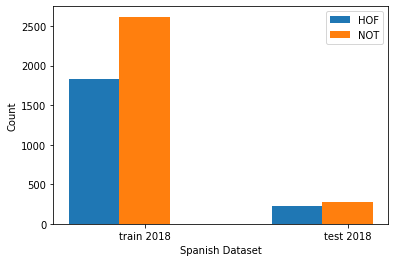

In [21]:
barWidth = 0.25
br1 = np.arange(len(SPANISH_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, SPANISH_HOF, width=barWidth, label='HOF')
plt.bar(br2, SPANISH_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('Spanish Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2018', 'test 2018'])

In [22]:
print(spanish_df_2019t[spanish_df_2019t['task_1'] == 0]['text'].iloc[39])
print(spanish_df_2019t[spanish_df_2019t['task_1'] == 1]['text'].iloc[10])

#Ciberactivismo por la Revolución y los #DerechosHumanos en #Túnez. #Mujeres en primera línea de la #revolución árabe.  https://t.co/2uFl6wUBD3
@VidalSieteDiez Tú eres la perra, no te dejes engañar.


###GERMAN DATASET ANALYSIS

In [23]:
GERMAN_HOF = []
GERMAN_NOT = []

In [24]:
german_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/german_dataset/german_dataset_2019.csv', error_bad_lines=False)
german_df_2019 = german_df_2019.drop(columns=['task_2'])
print(german_df_2019.shape)
labels = collections.Counter(german_df_2019['task_1'])
GERMAN_HOF.append(labels['HOF'])
GERMAN_NOT.append(labels['NOT'])
print(labels)
print(german_df_2019.columns)
german_df_2019.head()

(3819, 3)
Counter({'NOT': 3412, 'HOF': 407})
Index(['text_id', 'text', 'task_1'], dtype='object')


,text_id,text,task_1
0,hasoc_de_1,Frank Rennicke – Ich bin stolz https://t.co/Cm...,NOT
1,hasoc_de_2,ANSEHEN.....und danach bitte TEILEN...TEILEN.....,NOT
2,hasoc_de_3,#Koeln Mohamed erkennt kein deutsches Recht so...,NOT
3,hasoc_de_4,#SaudiArabien ist eine brutale islamische Dikt...,NOT
4,hasoc_de_5,Bundespolizei #München hat im 1. Quartal 2019 ...,NOT


In [25]:
# german_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/german_dataset/german_dataset_2020.csv', error_bad_lines=False)
# print(german_df_2020.columns)
# german_df_2020 = german_df_2020.drop(columns=['task2'])
# print(german_df_2020.shape)
# labels = collections.Counter(german_df_2020['task1'])
# GERMAN_HOF.append(labels['HOF'])
# GERMAN_NOT.append(labels['NOT'])
# print(labels)
# german_df_2020.head()

In [26]:
german_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/german_dataset/german_dataset_test_2020.csv', error_bad_lines=False)
print(german_df_2019t.columns)
german_df_2019t = german_df_2019t.drop(columns=['task2'])
print(german_df_2019t.shape)
labels = collections.Counter(german_df_2019t['task1'])
GERMAN_HOF.append(labels['HOF'])
GERMAN_NOT.append(labels['NOT'])
print(labels)
german_df_2019t.head()

Index(['tweet_id', 'text', 'task1', 'task2', 'ID'], dtype='object')
(526, 4)
Counter({'NOT': 392, 'HOF': 134})


,tweet_id,text,task1,ID
0,1129095874242650112,@derCarsti Boykottieren hört sich besser an. 💙💙,NOT,hasoc_2020_de_1053
1,1129004308396236800,"RT @ibikus31: Es wird spekuliert, ob Merkel ei...",NOT,hasoc_2020_de_671
2,1130896929355907080,Hat #Hitler wirklich den Krieg in der Wüste ve...,NOT,hasoc_2020_de_2977
3,1132251534329307136,RT @Beatrix_vStorch: #May tritt in UK unter Tr...,NOT,hasoc_2020_de_1746
4,1124941869115498496,@justmeDoro Eher nicht. Das Gänse hauen wieder...,NOT,hasoc_2020_de_2416


In [27]:
# german_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/english_dataset/english_dataset_test_2020.csv', error_bad_lines=False)
# german_df_2020t = german_df_2020t.drop(columns=['task2'])
# print(german_df_2020t.shape)
# print(german_df_2020t.columns)
# labels = collections.Counter(german_df_2020t['task1'])
# GERMAN_HOF.append(labels['HOF'])
# GERMAN_NOT.append(labels['NOT'])
# print(labels)
# german_df_2020t.head()

([<matplotlib.axis.XTick at 0x7f132a229550>,
 [Text(0, 0, 'train 2019'), Text(0, 0, 'test 2019')])

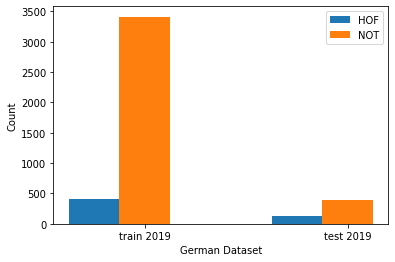

In [28]:
barWidth = 0.25
br1 = np.arange(len(GERMAN_HOF))
br2 = [x + barWidth for x in br1]
plt.bar(br1, GERMAN_HOF, width=barWidth, label='HOF')
plt.bar(br2, GERMAN_NOT, width=barWidth, label='NOT')
plt.legend()
plt.xlabel('German Dataset')
plt.ylabel('Count')
plt.xticks([r + barWidth for r in range(len(br1))],
        ['train 2019', 'test 2019'])

In [29]:
print(german_df_2019t[german_df_2019t['task1'] == 'HOF']['text'].iloc[39])
print(german_df_2019t[german_df_2019t['task1'] == 'NOT']['text'].iloc[150])

RT @yasinaygan: @TDoernb @alican_2023 @ProvoMed @welt Halts Maul du hurensohn deine Mutter ist stolz auf mich
#zdf was ist denn da bei euch los????


###HINDI DATASET ANALYSIS

In [30]:
# HINDI_HOF = []
# HINDI_NOT = []

In [31]:
# hindi_df_2019 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2019/hindi_dataset/hindi_dataset_2019.csv', error_bad_lines=False)
# hindi_df_2019 = hindi_df_2019.drop(columns=['task_2', 'task_3'])
# print(hindi_df_2019.shape)
# labels = collections.Counter(hindi_df_2019['task_1'])
# HINDI_HOF.append(labels['HOF'])
# HINDI_NOT.append(labels['NOT'])
# print(labels)
# print(hindi_df_2019.columns)
# hindi_df_2019.head()

In [32]:
# hindi_df_2020 = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/hindi_dataset/hindi_dataset_2020.csv', error_bad_lines=False)
# print(hindi_df_2020.columns)
# hindi_df_2020 = hindi_df_2020.drop(columns=['task2'])
# print(hindi_df_2020.shape)
# labels = collections.Counter(hindi_df_2020['task1'])
# HINDI_HOF.append(labels['HOF'])
# HINDI_NOT.append(labels['NOT'])
# print(labels)
# hindi_df_2020.head()

In [33]:
# hindi_df_2019t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/hindi_dataset/hindi_dataset_test_2020.csv', error_bad_lines=False)
# print(hindi_df_2019t.columns)
# hindi_df_2019t = hindi_df_2019t.drop(columns=['task2'])
# print(hindi_df_2019t.shape)
# labels = collections.Counter(hindi_df_2019t['task1'])
# HINDI_HOF.append(labels['HOF'])
# HINDI_NOT.append(labels['NOT'])
# print(labels)
# hindi_df_2019t.head()

In [34]:
# # hindi_df_2020t = pd.read_csv('/content/gdrive/My Drive/NLP Project/data/2020/hindi_dataset/hindi_dataset_test_2020.csv', error_bad_lines=False)
# hindi_df_2020t = hindi_df_2020t.drop(columns=['task2'])
# print(hindi_df_2020t.shape)
# print(hindi_df_2020t.columns)
# labels = collections.Counter(hindi_df_2020t['task1'])
# HINDI_HOF.append(labels['HOF'])
# HINDI_NOT.append(labels['NOT'])
# print(labels)
# hindi_df_2020t.head()

In [35]:
# barWidth = 0.25
# br1 = np.arange(len(HINDI_HOF))
# br2 = [x + barWidth for x in br1]
# plt.bar(br1, HINDI_HOF, width=barWidth, label='HOF')
# plt.bar(br2, HINDI_NOT, width=barWidth, label='NOT')
# plt.legend()
# plt.xlabel('Hindi Dataset')
# plt.ylabel('Count')
# plt.xticks([r + barWidth for r in range(len(br1))],
#         ['train 2019', 'test 2019'])

###COLLECTIVE DATASET ANALYSIS

In [36]:
total_hof = [np.sum(ENGLISH_HOF), np.sum(GERMAN_HOF), np.sum(SPANISH_HOF), np.sum(FRENCH_HOF)]
total_not = [np.sum(ENGLISH_NOT), np.sum(GERMAN_NOT), np.sum(SPANISH_HOF), np.sum(FRENCH_NOT)]

Text(0.5, 1.0, 'Hate Tweets')

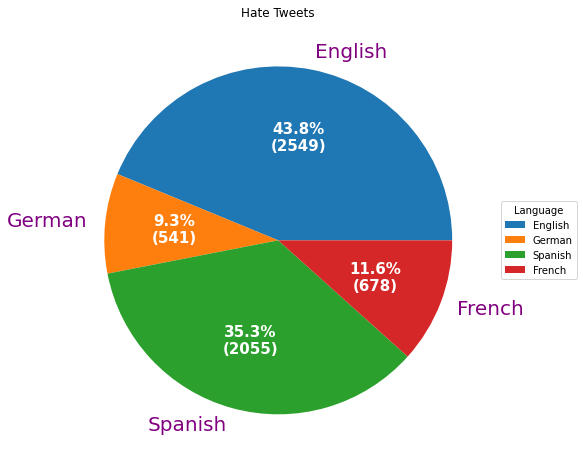

In [37]:
labels = ['English', 'German', 'Spanish', 'French']
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(total_hof, autopct=lambda pct: func(pct, total_hof),textprops=dict(color="purple", size=20), labels=labels)
ax.legend(wedges, labels,
          title="Language",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold", color="white")
ax.set_title("Hate Tweets")

Text(0.5, 1.0, 'Not Hate Tweets')

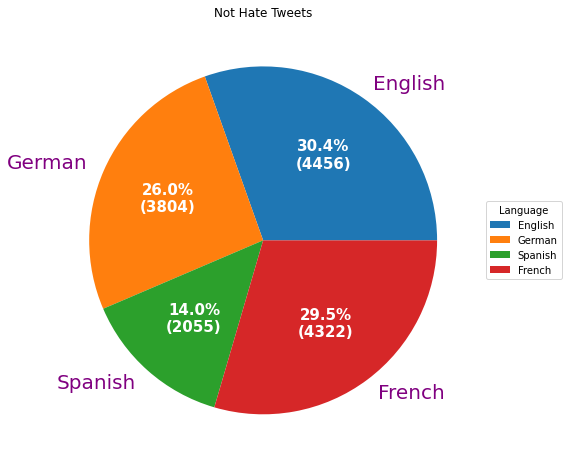

In [38]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(total_not, autopct=lambda pct: func(pct, total_not),textprops=dict(color="purple", size=20), labels=labels)
ax.legend(wedges, labels,
          title="Language",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold", color="white")
ax.set_title("Not Hate Tweets")

Text(0.5, 1.0, 'Language Distribution of Datasets')

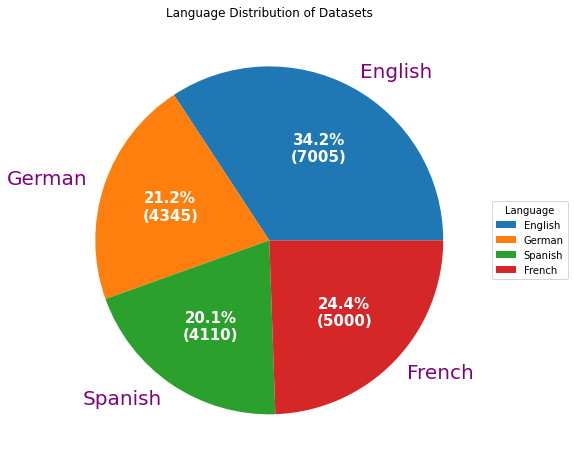

In [39]:
data = [a + b for a, b in zip(total_hof, total_not)]
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),textprops=dict(color="purple", size=20), labels=labels)
ax.legend(wedges, labels,
          title="Language",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold", color="white")
ax.set_title("Language Distribution of Datasets")

### CLEANING OF DATA - Remove STOP WORDS, tokens and twitter handles

In [40]:
def modify_tweets(data):
  # print(data.columns)
  modified_tweets = []
  for text in data:

      #To remove @AnyName from the tweets
      text=re.sub(r"@[a-zA-z0-9]*\s+","",text) 
      text=re.sub(r"@[a-zA-z0-9]*:","",text)
      text=re.sub(r"@[a-zA-z0-9]*","",text)  
      text=re.sub(r"@[a-zA-z0-9]*$","",text)
      
      #To remove links
      text=re.sub(r"^https://t.co/[a-zA-Z0-9]*\s+"," ",text)    
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s+"," ",text)  
      text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$"," ",text)    
      
      #To Convert all the tweets to low.
      # text=text.lower() 
      
      #To remove the shorthands
      text=re.sub(r"that's","that is ",text)
      text=re.sub(r"there's","there is ",text)
      text=re.sub(r"what's","what is ",text)
      text=re.sub(r"where's","where is ",text)
      text=re.sub(r"it's","it is ",text)
      text=re.sub(r"who's","who is ",text)
      text=re.sub(r"i'm","i am ",text)
      text=re.sub(r"she's","she is ",text)
      text=re.sub(r"he's","he is ",text)
      text=re.sub(r"they're","they are ",text)
      text=re.sub(r"who're","who are ",text)
      text=re.sub(r"ain't","am not ",text)
      text=re.sub(r"wouldn't","would not ",text)
      text=re.sub(r"shouldn't","should not ",text)
      text=re.sub(r"can't","cannot ",text)
      text=re.sub(r"couldn't","could not ",text)
      text=re.sub(r"won't","will not ",text)
      
      #To remove the single character
      text=re.sub(r"\s+[a-z]\s+"," ",text)
      text=re.sub(r"\s+[a-z]$"," ",text)
      text=re.sub(r"^[a-z]\s+"," ",text)
      
      #To remove non-word character
      text=re.sub(r"^[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*\s+"," ",text)
      text=re.sub(r"\s+[「人間はいわば感情に左右される生き物である」]*$"," ",text)
      text=re.sub(r"[!@$,%^&*\"><]*","",text)
      text=re.sub(r"\."," ",text)
      
      #To remove duplicate spaces
      text=re.sub(r"\s+"," ",text)
      
      #To remove digits 
      text=re.sub(r"\d"," ",text)
      
      #To remove non-word characters
      text=re.sub(r"\W"," ",text)
      
      modified_tweets.append(text)
  return modified_tweets

In [41]:
print(english_df_2019.head(1)['text'])
english_df_2019['text'] = modify_tweets(english_df_2019['text'])
print(english_df_2019.head(1)['text'])

print(english_df_2019t.head(1)['text'])
english_df_2019t['text'] = modify_tweets(english_df_2019t['text'])
print(english_df_2019t.head(1)['text'])

# print(english_df_2020.head(1)['text'])
# english_df_2020['text'] = modify_tweets(english_df_2020['text'])
# print(english_df_2020.head(1)['text'])

# print(english_df_2020t.head(1)['text'])
# english_df_2020t['text'] = modify_tweets(english_df_2020t['text'])
# print(english_df_2020t.head(1)['text'])

0    #DhoniKeepsTheGlove | WATCH: Sports Minister K...
Name: text, dtype: object
0     DhoniKeepsTheGlove   WATCH  Sports Minister K...
Name: text, dtype: object
0    West Bengal Doctor Crisis: Protesting doctors ...
Name: text, dtype: object
0    West Bengal Doctor Crisis  Protesting doctors ...
Name: text, dtype: object


In [42]:
print(german_df_2019.head(1)['text'])
german_df_2019['text'] = modify_tweets(german_df_2019['text'])
print(german_df_2019.head(1)['text'])

print(german_df_2019t.head(1)['text'])
german_df_2019t['text'] = modify_tweets(german_df_2019t['text'])
print(german_df_2019t.head(1)['text'])

# print(german_df_2020.head(1)['text'])
# german_df_2020['text'] = modify_tweets(german_df_2020['text'])
# print(german_df_2020.head(1)['text'])

# print(german_df_2020t.head(1)['text'])
# german_df_2020t['text'] = modify_tweets(german_df_2020t['text'])
# print(german_df_2020t.head(1)['text'])

0    Frank Rennicke – Ich bin stolz https://t.co/Cm...
Name: text, dtype: object
0    Frank Rennicke   Ich bin stolz 
Name: text, dtype: object
0    @derCarsti Boykottieren hört sich besser an. 💙💙
Name: text, dtype: object
0    Boykottieren hört sich besser an   
Name: text, dtype: object


In [43]:
print(spanish_df_2019.head(1)['text'])
spanish_df_2019['text'] = modify_tweets(spanish_df_2019['text'])
print(spanish_df_2019.head(1)['text'])

print(spanish_df_2019t.head(1)['text'])
spanish_df_2019t['text'] = modify_tweets(spanish_df_2019t['text'])
print(spanish_df_2019t.head(1)['text'])

0    Easyjet quiere duplicar el número de mujeres p...
Name: text, dtype: object
0    Easyjet quiere duplicar el número de mujeres p...
Name: text, dtype: object
0    Me estoy comiendo la picada árabe más rica de ...
Name: text, dtype: object
0    Me estoy comiendo la picada árabe más rica de ...
Name: text, dtype: object


In [44]:
# def modify_hindi_tweets(data):
#   # print(data.columns)
#   modified_tweets = []
#   for text in data:

#       #To remove @AnyName from the tweets
#       text=re.sub(r"@[a-zA-z0-9]*\s+","",text) 
#       text=re.sub(r"@[a-zA-z0-9]*:","",text)
#       text=re.sub(r"@[a-zA-z0-9]*","",text)  
#       text=re.sub(r"@[a-zA-z0-9]*$","",text)
      
#       #To remove links
#       text=re.sub(r"^https://t.co/[a-zA-Z0-9]*\s+"," ",text)    
#       text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s+"," ",text)  
#       text=re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$"," ",text) 

#       #To remove duplicate spaces
#       text=re.sub(r"\s+"," ",text)
      
#       #To remove digits 
#       text=re.sub(r"\d"," ",text)
      
#       #To remove non-word characters
#       text=re.sub(r"\#"," ",text)
    
#       modified_tweets.append(text)
#   return modified_tweets

# print(hindi_df_2019.head(1)['text'])
# l = modify_hindi_tweets(hindi_df_2019['text'])
# print(l[0])
# hindi_df_2019['text'] = l
# print(hindi_df_2019.head(1)['text'])

# print(hindi_df_2019t.head(1)['text'])
# hindi_df_2019t['text'] = modify_hindi_tweets(hindi_df_2019t['text'])
# print(hindi_df_2019t.head(1)['text'])

# # print(hindi_df_2020.head(1)['text'])
# # hindi_df_2020['text'] = modify_hindi_tweets(hindi_df_2020['text'])
# # print(hindi_df_2020.head(1)['text'])

# # print(hindi_df_2020t.head(1)['text'])
# # hindi_df_2020t['text'] = modify_hindi_tweets(hindi_df_2020t['text'])
# # print(hindi_df_2020t.head(1)['text'])

### Utility functions



1. encoder_generator(documents)
2. predictions_labels(preds,labels)
3. categorical_accuracy(preds, y)
4. predictions_labels(preds,labels)
5. train(model, train_data_loader)
6. evaluate(model, valid_data_loader)
7. evaluate_test(model, test_data_loader)
8. epoch_time(start_time, end_time)
9. plot_vc(acc_train, acc_val)
10. plot_loss(loss_train, loss_val)



In [45]:
def encoder_generator(tokenizer, documents):
    
    doc_index = []
    input_ids = []
    attention_masks =[]

    for index,doc in enumerate(documents):
        
        doc_index.append(index)
        
        encoded_dict = tokenizer.encode_plus(doc,
                                             add_special_tokens=True,
                                             max_length=128,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    sent_index = torch.tensor(doc_index)

    return sent_index,input_ids,attention_masks


In [46]:
def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [47]:
def train(model, train_data_loader, optimizer):
    total_train_loss = 0
    total_train_acc = 0
    
    model.train() # set model in train mode for batchnorm and dropout layers in bert model
    
    for step,batch in enumerate(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
            
        output = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels.long())
        loss = output.loss
        logits = output.logits

        total_train_loss+=loss.item()
        total_train_acc+=categorical_accuracy(logits,b_labels).item()
            
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
        optimizer.step()
            
        scheduler.step() #go ahead and update the learning rate
            
    avg_train_loss = total_train_loss/len(train_data_loader)
    avg_train_acc = total_train_acc/len(train_data_loader)
    
    return avg_train_loss,avg_train_acc

In [48]:
def evaluate(model, valid_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []

    for batch in valid_data_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
        loss = output.loss
        logits = output.logits

        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')
    
    avg_val_loss = total_eval_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [49]:
def evaluate_test(model, test_data_loader):
    model.eval()
        
    total_eval_accuracy = 0
    total_eval_loss = 0
    number_of_eval_steps= 0
    
    all_true_labels = []
    all_pred_labels = []
    
    all_sentence_id=[]

    for batch in test_data_loader:
        b_sentence_id = batch[0].to(device)
        b_input_ids = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)

        sent_ids = b_sentence_id.to('cpu').numpy()
        all_sentence_id.extend(sent_ids)
        
        with torch.no_grad():

            output = model(b_input_ids,
                                attention_mask= b_input_mask,
                                labels = b_labels.long())
            
        loss = output.loss
        logits = output.logits
        
        total_eval_loss+=loss.item()

        logits = logits.detach().cpu().numpy()

        label_ids = b_labels.to('cpu').numpy()
        

        pred,true = predictions_labels(logits,label_ids)
        
        all_pred_labels.extend(pred)
        
        all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    
    avg_val_loss = total_eval_loss/len(test_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))
    
    return avg_val_loss,avg_val_accuracy,all_sentence_id,all_pred_labels


In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [51]:
def plot_vc(acc_train, acc_val):
  e = range(epochs)
  plt.plot(e, acc_train, 'g', label='Training Accuracy')
  plt.plot(e, acc_val, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [52]:
def plot_lc(loss_train, loss_val):
  e = range(epochs)
  plt.plot(e, loss_train, 'g', label='Training Loss')
  plt.plot(e, loss_val, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## FRENCH TUNING

###Load French Data

In [ ]:
train_data_fr = french_df_2019.copy()
test_data_fr = french_df_2019t.copy()
# labels = {'HOF': 1, 'NOT': 0}

# train_data['HS'] = train_data['HS'].apply(lambda x: labels[x])
# test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

tokenizer_fr = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

max_length = 0
for sentence in train_data_fr['text']:
    #print(sentence)
    length = len(tokenizer_fr.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_fr,input_ids_fr,attention_masks_fr = encoder_generator(tokenizer_fr, list(train_data_fr['text']))
test_sent_index_fr,test_input_ids_fr,test_attention_masks_fr = encoder_generator(tokenizer_fr, list(test_data_fr['text']))
# print('Original: ', train_data_fr['text'][0])
# print('Token IDs:', input_ids_fr[0])
dataset_fr = TensorDataset(input_ids_fr,attention_masks_fr,torch.tensor(train_data_fr['label']))
test_dataset_fr = TensorDataset(test_sent_index_fr,test_input_ids_fr,test_attention_masks_fr,torch.tensor(test_data_fr['label']))

train_size_fr = int(0.8*len(dataset_fr))

val_size_fr = len(dataset_fr)-train_size_fr

train_dataset_fr,val_dataset_fr = random_split(dataset_fr,[train_size_fr,val_size_fr])

print('train data samples is {}'.format(len(train_dataset_fr)))
print("valid data samples is {}".format(len(val_dataset_fr)))
print("test data samples is {}".format(len(test_dataset_fr)))

bs=8

train_data_loader_fr = DataLoader(train_dataset_fr,
                              sampler=RandomSampler(train_dataset_fr),
                              batch_size=bs)
valid_data_loader_fr = DataLoader(val_dataset_fr,
                              sampler=SequentialSampler(val_dataset_fr),
                              batch_size=bs)
test_data_loader_fr = DataLoader(test_dataset_fr,
                            sampler=SequentialSampler(test_dataset_fr),
                            batch_size=bs)


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

max token length in train_data is:  66


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


train data samples is 3200
valid data samples is 800
test data samples is 1000


### Train BERT on FRENCH




In [ ]:
# if model_eng:
# del model_fr
import gc
gc.collect()

from transformers import BertForSequenceClassification, AdamW


model_fr = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                     num_labels=2,
                                                     output_attentions=False,
                                                     output_hidden_states=False,
                                                     )
model_fr.cuda()

optimizer_fr = AdamW(model_fr.parameters(),lr=2e-5,eps=1e-8)

epochs=10
total_steps = len(train_data_loader_fr) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_fr,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

total_t0 = time.time()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

epochs = 10

best_macro_f1 = float('0')
train_acc_eng_fr = []
val_acc_eng_fr = []
train_loss_eng_fr = []
val_loss_eng_fr = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc = train(model_fr, train_data_loader_fr, optimizer_fr)
    valid_loss,valid_acc,macro_f1 = evaluate(model_fr, valid_data_loader_fr)
    
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(model_fr,"/content/gdrive/MyDrive/NLP Project/model_pt/model_french_task_a.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_acc_eng_fr.append(train_acc*100)
    val_acc_eng_fr.append(valid_acc*100)
    train_loss_eng_fr.append(train_loss*100)
    val_loss_eng_fr.append(valid_loss*100)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

              precision    recall  f1-score   support

           0       1.00      0.83      0.91       800
           1       0.00      0.00      0.00         0

    accuracy                           0.83       800
   macro avg       0.50      0.42      0.45       800
weighted avg       1.00      0.83      0.91       800

accuracy = 0.83
Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 0.422 | Train Acc: 85.38%
	 Val. Loss: 0.465 |  Val. Acc: 83.25%
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       754
           1       0.21      0.61      0.31        46

    accuracy                           0.84       800
   macro avg       0.59      0.73      0.61       800
weighted avg       0.93      0.84      0.88       800

accuracy = 0.84
Epoch: 02 | Epoch Time: 0m 59s
	Train Loss: 0.374 | Train Acc: 86.72%
	 Val. Loss: 0.499 |  Val. Acc: 84.50%
              precision    recall  f1-score   support

           0       0.98      0.84      0.

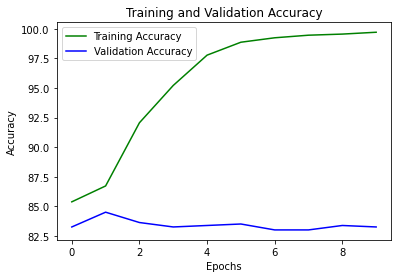

95.403125
83.4125


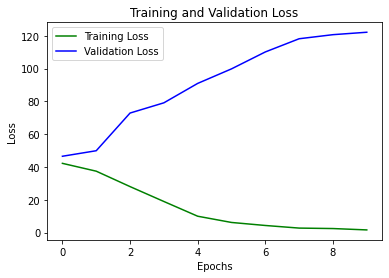

15.368400997666322
91.0500078084413


In [ ]:
plot_vc(train_acc_eng_fr, val_acc_eng_fr)
print(np.mean(train_acc_eng_fr))
print(np.mean(val_acc_eng_fr))

plot_lc(train_loss_eng_fr, val_loss_eng_fr)
print(np.mean(train_loss_eng_fr))
print(np.mean(val_loss_eng_fr))

###Evaluate French

In [ ]:
del model_fr
import gc
gc.collect()

model_fr = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_french_task_a.pt")
model_fr = model_fr.to(device)

valid_loss_fr,valid_acc_fr,all_sentence_id_fr,all_pred_labels_fr = evaluate_test(model_fr, test_data_loader_fr)

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       911
           1       0.31      0.49      0.38        89

    accuracy                           0.86      1000
   macro avg       0.63      0.69      0.65      1000
weighted avg       0.89      0.86      0.87      1000

accuracy = 0.86


##SPANISH TUNING

###Load Spanish Data

In [ ]:
train_data_sp = spanish_df_2019.copy()
test_data_sp = spanish_df_2019t.copy()
labels = {'HOF': 0, 'NOT': 1}

# train_data['HS'] = train_data['HS'].apply(lambda x: labels[x])
# test_data['task_1'] = test_data['task_1'].apply(lambda x: labels[x])

tokenizer_sp = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

max_length = 0
for sentence in train_data_sp['text']:
    #print(sentence)
    length = len(tokenizer_sp.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_sp,input_ids_sp,attention_masks_sp = encoder_generator(tokenizer_sp, list(train_data_sp['text']))
test_sent_index_sp,test_input_ids_sp,test_attention_masks_sp = encoder_generator(tokenizer_sp, list(test_data_sp['text']))
print('Original: ', train_data_sp['text'][0])
print('Token IDs:', input_ids_sp[0])
dataset_sp = TensorDataset(input_ids_sp,attention_masks_sp,torch.tensor(train_data_sp['HS']))
test_dataset_sp = TensorDataset(test_sent_index_sp,test_input_ids_sp,test_attention_masks_sp,torch.tensor(test_data_sp['task_1']))

train_size_sp = int(0.8*len(dataset_sp))

val_size_sp = len(dataset_sp)-train_size_sp

train_dataset_sp,val_dataset_sp = random_split(dataset_sp,[train_size_sp,val_size_sp])

print('train data samples is {}'.format(len(train_dataset_sp)))
print("valid data samples is {}".format(len(val_dataset_sp)))
print("test data samples is {}".format(len(test_dataset_sp)))

bs=8

train_data_loader_sp = DataLoader(train_dataset_sp,
                              sampler=RandomSampler(train_dataset_sp),
                              batch_size=bs)
valid_data_loader_sp = DataLoader(val_dataset_sp,
                              sampler=SequentialSampler(val_dataset_sp),
                              batch_size=bs)
test_data_loader_sp = DataLoader(test_dataset_sp,
                            sampler=SequentialSampler(test_dataset_sp),
                            batch_size=bs)


max token length in train_data is:  1229


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Easyjet quiere duplicar el número de mujeres piloto  Verás tú para aparcar el avión http   t co   NuLkm  x
Token IDs: tensor([  101, 39878, 18533, 68448, 10168, 62932, 15983, 10125, 13197, 10104,
        22354, 35635, 41357, 12299, 85777, 10220, 32500, 22549, 10129, 10125,
        48537, 10556,   188, 11170, 28336, 11369, 23440,   192,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

### Evaluate BERT(French) on Spanish Val Data

Bert trained on English and evaluated

In [ ]:
# if model_sp:
#   del model_sp
import gc
gc.collect()

model_sp = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_french_task_a.pt")
model_sp = model_sp.to(device)

valid_loss_sp,valid_acc_sp,all_sentence_id_sp,all_pred_labels_sp = evaluate_test(model_sp, test_data_loader_sp)

              precision    recall  f1-score   support

           0       0.87      0.55      0.68       440
           1       0.11      0.42      0.18        60

    accuracy                           0.54       500
   macro avg       0.49      0.48      0.43       500
weighted avg       0.78      0.54      0.62       500

accuracy = 0.54


### Train Fine tuned BERT (French) for Spanish


In [ ]:
del model_fr
import gc
gc.collect()

model_fr = torch.load('/content/gdrive/MyDrive/NLP Project/model_pt/model_french_task_a.pt')
model_fr = model_fr.to(device)

optimizer_sp = AdamW(model_fr.parameters(),lr=2e-5,eps=1e-8)

epochs=10
total_steps = len(train_data_loader_sp) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_sp,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

total_t0 = time.time()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

epochs = 10

best_macro_f1 = float('0')
train_acc_eng_sp = []
val_acc_eng_sp = []
train_loss_eng_sp = []
val_loss_eng_sp = []

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc = train(model_fr, train_data_loader_sp, optimizer_sp)
    valid_loss,valid_acc,macro_f1 = evaluate(model_fr, valid_data_loader_sp)
    
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(model_fr,"/content/gdrive/MyDrive/NLP Project/model_pt/model_french_spanish_task_a.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_acc_eng_sp.append(train_acc*100)
    val_acc_eng_sp.append(valid_acc*100)
    train_loss_eng_sp.append(train_loss*100)
    val_loss_eng_sp.append(valid_loss*100)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       466
           1       0.84      0.69      0.75       424

    accuracy                           0.79       890
   macro avg       0.80      0.78      0.78       890
weighted avg       0.79      0.79      0.78       890

accuracy = 0.79
Epoch: 01 | Epoch Time: 1m 6s
	Train Loss: 0.617 | Train Acc: 68.60%
	 Val. Loss: 0.493 |  Val. Acc: 78.65%
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       396
           1       0.92      0.65      0.76       494

    accuracy                           0.78       890
   macro avg       0.80      0.79      0.77       890
weighted avg       0.81      0.78      0.77       890

accuracy = 0.78
Epoch: 02 | Epoch Time: 1m 6s
	Train Loss: 0.446 | Train Acc: 82.87%
	 Val. Loss: 0.613 |  Val. Acc: 77.53%
              precision    recall  f1-score   support

           0       0.81      0.85      0.83

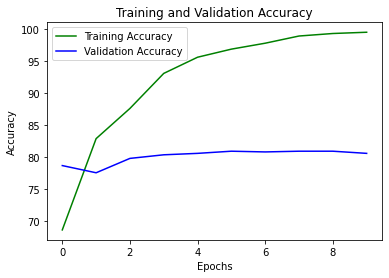

92.00280898876403
80.08988764044942


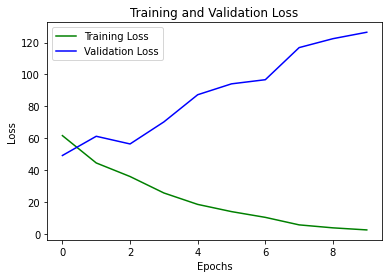

22.449450615620812
88.13136611124719


In [ ]:
plot_vc(train_acc_eng_sp, val_acc_eng_sp)
print(np.mean(train_acc_eng_sp))
print(np.mean(val_acc_eng_sp))

plot_lc(train_loss_eng_sp, val_loss_eng_sp)
print(np.mean(train_loss_eng_sp))
print(np.mean(val_loss_eng_sp))

###Evaluate BERT french-> Span

In [ ]:
# if model_sp:
#   del model_sp
import gc
gc.collect()

model_sp = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_french_spanish_task_a.pt")
model_sp = model_sp.to(device)

valid_loss_sp,valid_acc_sp,all_sentence_id_sp,all_pred_labels_sp = evaluate_test(model_sp, test_data_loader_sp)

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       248
           1       0.83      0.73      0.78       252

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

accuracy = 0.79


##GERMAN TUNING

### Load German data

In [ ]:
train_data_ger = german_df_2019.copy()
test_data_ger = german_df_2019t.copy()
labels = {'HOF': 0, 'NOT': 1}

train_data_ger['task_1'] = train_data_ger['task_1'].apply(lambda x: labels[x])
test_data_ger['task1'] = test_data_ger['task1'].apply(lambda x: labels[x])

tokenizer_ger = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

max_length = 0
for sentence in train_data_ger['text']:
    #print(sentence)
    length = len(tokenizer_ger.tokenize(sentence))
    if length > max_length:
        max_length  = length
print("max token length in train_data is: ",max_length)

sent_index_ger,input_ids_ger,attention_masks_ger = encoder_generator(tokenizer_ger, list(train_data_ger['text']))
test_sent_index_ger,test_input_ids_ger,test_attention_masks_ger = encoder_generator(tokenizer_ger, list(test_data_ger['text']))
print('Original: ', train_data_ger['text'][0])
print('Token IDs:', input_ids_ger[0])
dataset_ger = TensorDataset(input_ids_ger,attention_masks_ger,torch.tensor(train_data_ger['task_1']))
test_dataset_ger = TensorDataset(test_sent_index_ger,test_input_ids_ger,test_attention_masks_ger,torch.tensor(test_data_ger['task1']))

train_size_ger = int(0.8*len(dataset_ger))

val_size_ger = len(dataset_ger)-train_size_ger

train_dataset_ger,val_dataset_ger = random_split(dataset_ger,[train_size_ger,val_size_ger])

print('train data samples is {}'.format(len(train_dataset_ger)))
print("valid data samples is {}".format(len(val_dataset_ger)))
print("test data samples is {}".format(len(test_dataset_ger)))

bs=8

train_data_loader_ger = DataLoader(train_dataset_ger,
                              sampler=RandomSampler(train_dataset_ger),
                              batch_size=bs)
valid_data_loader_ger = DataLoader(val_dataset_ger,
                              sampler=SequentialSampler(val_dataset_ger),
                              batch_size=bs)
test_data_loader_ger = DataLoader(test_dataset_ger,
                            sampler=SequentialSampler(test_dataset_ger),
                            batch_size=bs)


max token length in train_data is:  132


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Frank Rennicke   Ich bin stolz 
Token IDs: tensor([  101, 11872, 52712, 71609, 10112, 21023, 16292, 47264, 48275,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

### Evaluate BERT(French) on German Val Data

Bert trained on English and evaluated

In [ ]:
# if model_ger:
#   del model_ger
import gc
gc.collect()

model_ger = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_french_task_a.pt")
model_ger = model_ger.to(device)

valid_loss_ger,valid_acc_ger,all_sentence_id_ger,all_pred_labels_ger = evaluate_test(model_ger, test_data_loader_ger)

              precision    recall  f1-score   support

           0       0.90      0.27      0.42       449
           1       0.16      0.83      0.27        77

    accuracy                           0.35       526
   macro avg       0.53      0.55      0.34       526
weighted avg       0.79      0.35      0.39       526

accuracy = 0.35


###Train Fine tuned BERT (French) for German

In [ ]:
# if model_eng:
#   del model_eng
import gc
gc.collect()

model_eng = torch.load('/content/gdrive/MyDrive/NLP Project/model_pt/model_french_task_a.pt')
model_eng = model_eng.to(device)

optimizer_ger = AdamW(model_eng.parameters(),lr=2e-5,eps=1e-8)

epochs=10
total_steps = len(train_data_loader_ger) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer_ger,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

total_t0 = time.time()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

epochs = 10

best_macro_f1 = float('0')
train_acc_eng_ger = []
val_acc_eng_ger = []
train_loss_eng_ger=[]
val_loss_eng_ger=[]

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc = train(model_eng, train_data_loader_ger, optimizer_ger)
    valid_loss,valid_acc,macro_f1 = evaluate(model_eng, valid_data_loader_ger)
    
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(model_eng,"/content/gdrive/MyDrive/NLP Project/model_pt/model_french_german_task_a.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_acc_eng_ger.append(train_acc*100)
    val_acc_eng_ger.append(valid_acc*100)
    train_loss_eng_ger.append(train_loss*100)
    val_loss_eng_ger.append(valid_loss*100)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 0.382 | Train Acc: 88.58%
	 Val. Loss: 0.335 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 0.351 | Train Acc: 89.17%
	 Val. Loss: 0.413 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 03 | Epoch Time: 0m 56s
	Train Loss: 0.359 | Train Acc: 89.17%
	 Val. Loss: 0.358 |  Val. Acc: 90.05%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95       764

    accuracy                           0.90       764
   macro avg       0.50      0.45      0.47       764
weighted avg       1.00      0.90      0.95       764

accuracy = 0.90
Epoch: 04 | Epoch Time: 0m 56s
	Train Loss: 0.354 | Train Acc: 89.16%
	 Val. Loss: 0.337 |  Val. Acc: 90.05%
              precision    recall  f1-score   support

           0       0.17      0.27      0.21        49
           1       0.95      0.91      0.93       715

    accuracy                           0.87       764
   macro avg       0.56      0.59      0.57       764
weighted avg       0.90      0.87      0.88       764

accuracy = 0.87
Epoch: 05 | Epoch Time: 0m 56s
	Train Loss: 0.339 | Train Acc: 88.80%
	 Val. Loss: 0.324 |  Val. Acc: 87.04%
              precision    recall  f1-score   support

           0       0.05      0.36      0.

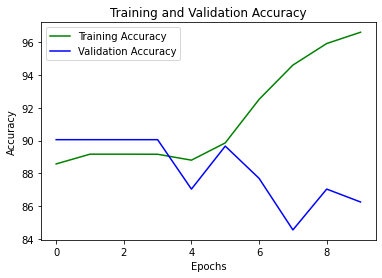

91.43464846760814
88.24607329842931


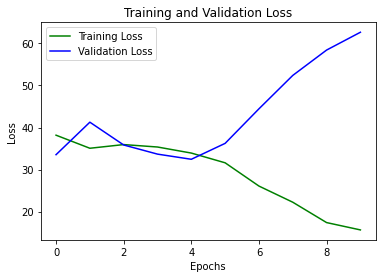

29.13815866006265
43.094042387335016


In [ ]:
plot_vc(train_acc_eng_ger, val_acc_eng_ger)
print(np.mean(train_acc_eng_ger))
print(np.mean(val_acc_eng_ger))

plot_lc(train_loss_eng_ger, val_loss_eng_ger)
print(np.mean(train_loss_eng_ger))
print(np.mean(val_loss_eng_ger))

###Evaluate BERT French->GER

In [ ]:
# if model_ger:
#   del model_ger
import gc
gc.collect()

model_ger = torch.load("/content/gdrive/MyDrive/NLP Project/model_pt/model_french_german_task_a.pt")
model_ger = model_ger.to(device)

valid_loss_ger,valid_acc_ger,all_sentence_id_ger,all_pred_labels_ger = evaluate_test(model_ger, test_data_loader_ger)

              precision    recall  f1-score   support

           0       0.38      0.50      0.43       103
           1       0.87      0.80      0.83       423

    accuracy                           0.74       526
   macro avg       0.62      0.65      0.63       526
weighted avg       0.77      0.74      0.76       526

accuracy = 0.74


### TODO



*   Plot loss curve instead of accuracy curve [DONE]
*   Verify the code flow and variable names [DONE]
*   Results not good? Analyze the tokens generated - how much similar and how not. [DONE]

---

*   Data Augmentation [TBD]





